In [92]:
#based on https://github.com/yuanqqq/SIN
from flax import linen as nn
import numpy as np
from typing import Any, Callable, Optional, Tuple, Type, List
from jax import lax, random, numpy as jnp
import einops
import torchio
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import jax
import tensorflow as tf
import torch 
import einops
import torchio as tio
import optax
from flax.training import train_state  
from torch.utils.data import DataLoader
import jax.profiler
import ml_collections
from ml_collections import config_dict
from functools import partial
import toolz
import chex
import pandas as pd
from flax.linen import partitioning as nn_partitioning
remat = nn_partitioning.remat

from jax.config import config
config.update('jax_platform_name', 'cpu')

jax.numpy.set_printoptions(linewidth=800)

def get_diameter_no_pad(r):
    """
    so every time we have n elements we can get n+ more elements
    so analyzing on single axis
    start from 1 ->1+1+1 =3 good
    start from 3 ->3+3+1=7 good 
    start from 7 ->7+7+1=15 good 
    """
    curr = 1
    for i in range(0,r):
        curr=curr*2+1
    return curr

def get_diameter(r):
    return get_diameter_no_pad(r)+1


def disp_to_pandas(probs,shappe ):
    probs_to_disp= einops.rearrange(probs,'w h c-> (w h) c')
    probs_to_disp=jnp.round(probs_to_disp,1)
    probs_to_disp=list(map(lambda twoo: f"{twoo[0]} {twoo[1]}",list(probs_to_disp)))
    probs_to_disp=np.array(probs_to_disp).reshape(shappe)
    return pd.DataFrame(probs_to_disp)

def disp_to_pandas_curr_shape(probs ):
    return disp_to_pandas(probs,(probs.shape[0],probs.shape[1]) )



def roll_in(probs,dim_stride,probs_shape):
    """
    as the probabilities are defined on already on dilatated array we have a lot of redundancy
    basically if new layer A looks forwrd to old layer B it is the same as old layer B looking at A
    hence after this function those two informations will be together in last dimension
    as we can see we are also getting rid here of looking back at first and looking forward at last
    becouse they are looking at nothinh - we will reuse one of those later     
    """
    probs_back=probs[:,:,0]
    probs_forward=probs[:,:,1]
    probs_back=jnp.take(probs_back, indices=jnp.arange(1,probs_shape[dim_stride]),axis=dim_stride )
    probs_forward=jnp.take(probs_forward, indices=jnp.arange(0,probs_shape[dim_stride]-1),axis=dim_stride )
    # print(f"to_ends {to_ends.shape} probs_back {probs_back.shape}  probs_forward {probs_forward.shape}")

    # probs_back = jnp.concatenate((to_ends,probs_back) ,axis= dim_stride )
    # probs_forward = jnp.concatenate((probs_forward,to_ends) ,axis= dim_stride )
    # print(f"to_ends {to_ends.shape} probs_back {probs_back.shape}  probs_forward {probs_forward.shape}")
    
    probs=jnp.stack([probs_forward,probs_back],axis=-1)
    return probs

def grid_build(res_grid,probs,dim_stride,probs_shape, grid_shape,orig_grid_shape
                ,rearrange_to_intertwine_einops, recreate_channels_einops):
    """
    we will dilatate the grid of the supervoxels ids (each id is 3 float 16) on the basis of the supplied probabilities
    and old undilatated grid voxels ids - additionally there is a problem
    big problems is that intepolation algorithm is deciding always weather to get a new voxel backward or forward in axis
    hence there is no single good solution 
    we will just add the  voxel id to the end and use the probability of the last prob layer as probability of this new voxel
    this id will be bigger than the max id present in original voxel grid
    """
    num_dims=2 #number of dimensions we are analyzing 2 in debugging 3 in final
    #rolling and summing the same information
    rolled_probs=roll_in(probs,dim_stride,probs_shape)
    rolled_probs = jnp.sum(rolled_probs,axis=-1)
    # retaking this last probability looking out that was discarded in roll in
    end_prob=jnp.take(probs, indices=probs_shape[dim_stride]-1,axis=dim_stride )
    end_prob=jnp.expand_dims(end_prob,dim_stride)[:,:,1]*2 #times 2 as it was not summed up
    rolled_probs = jnp.concatenate((rolled_probs,end_prob) ,axis= dim_stride )
    #rearranging two get last dim =2 so the softmax will make sense
    rolled_probs=einops.rearrange(rolled_probs,recreate_channels_einops,c=2 ) 
    rolled_probs= nn.softmax(rolled_probs,axis=-1)
    # making it as close to 0 and 1 as possible not hampering differentiability
    # as all other results will lead to inconclusive grid id

    # probs = v_harder_diff_round(probs)*0.5
    rolled_probs = jnp.round(rolled_probs) #TODO(it is non differentiable !)  
    # preparing the propositions to which the probabilities will be apply
    # to choose weather we want the grid id forward or back the axis
    grid_forward=jnp.take(res_grid, indices=jnp.arange(1,grid_shape[dim_stride]),axis=dim_stride )
    grid_back =jnp.take(res_grid, indices=jnp.arange(0,grid_shape[dim_stride]),axis=dim_stride )
    #now we need also to add the last 
    grid_shape_list=list(grid_shape)
    grid_shape_list[dim_stride]=1
    to_end_grid=jnp.zeros(tuple([grid_shape_list[0],grid_shape_list[1],num_dims]))+orig_grid_shape[dim_stride]+1
    grid_forward= jnp.concatenate((grid_forward,to_end_grid) ,axis= dim_stride)

    #in order to reduce rounding error we will work on diffrences not the actual values
    # bellow correcting also the sign of the last in analyzed axis
    diff_a=grid_back-grid_forward
    diff_b=grid_forward-grid_back
    grid_proposition_diffs=jnp.stack([diff_a,diff_b],axis=-1)
    #in order to broadcast we add empty dim - needed becouse probability is about whole point not the each coordinate of sv id
    rolled_probs=einops.rearrange(rolled_probs,'h w p-> h w p 1')
    grid_accepted_diffs= jnp.multiply(grid_proposition_diffs, rolled_probs)
    # print(f"grid_accepted_diffs {grid_accepted_diffs}")

    #get back the values of the decision as we subtracted and now add we wil get exactly the same
    # values for both entries example:
    # a=10
    # b=8
    # mask_a=np.multiply(np.array([a-b , b-a]),np.array([1,0]))
    # mask_b=np.multiply(np.array([a-b , b-a]),np.array([0,1]))
    # np.array([b,a])+mask_a will give 8,8
    # np.array([b,a])+mask_b will give 10,10
    grid_accepted_diffs=(grid_accepted_diffs+jnp.stack([grid_forward,grid_back],axis=-1))
    res_grid_new=grid_accepted_diffs[:,:,:,1]
    
    # res_grid_new=res_grid.at[:,:,dim_stride].set(grid_accepted_diffs)
    #intertwining
    res= einops.rearrange([res_grid,res_grid_new],  rearrange_to_intertwine_einops ) 
    # res=res.take(indices=jnp.arange(grid_shape[dim_stride]*2 -1) ,axis=dim_stride)
    return res
    # rolled_probs= jnp.sum(rolled_probs,axis=-1)

def for_pad_divide_grid(current_grid_shape:Tuple[int],axis:int,r:int,shift:int,orig_grid_shape:Tuple[int],diameter:int):
    """
    helper function for divide_sv_grid in order to calculate padding
    additionally give the the right infor for cut
    """

    #calculating the length of the axis after all of the cuts and paddings
    #for example if we have no shift we need to add r at the begining of the axis
    r_to_pad=(get_diameter_no_pad(r)-1)//2

    for_pad_beg=r_to_pad*(1-shift)
    #wheather we want to remove sth from end or not depend wheater we have odd or even amountof supervoxel ids in this axis
    is_even=int((orig_grid_shape[axis]%2==0))
    is_odd=1-is_even
    to_remove_from_end= (shift*is_odd)*r_to_pad + ((1-shift)*is_even)*r_to_pad
    axis_len_prim=for_pad_beg+current_grid_shape[axis]-to_remove_from_end
    #how much padding we need to make it divisible by diameter
    for_pad_rem= np.remainder(axis_len_prim,diameter)
    to_pad_end=diameter-np.remainder(axis_len_prim,diameter)
    if(for_pad_rem==0):
        to_pad_end=0
    axis_len=axis_len_prim+to_pad_end    
    return for_pad_beg,to_remove_from_end,axis_len_prim,axis_len,to_pad_end       


def get_supervoxel_ids(shift_x:bool,shift_y:bool,orig_grid_shape:Tuple[int]):
    """
    In order to be able to vmap through the supervoxels we need to have a way 
    to tell what id should be present in the area we have and that was given by main part of 
    divide_sv_grid function the supervoxel ids are based on the orig_grid_shape  generally 
    we have the supervoxel every r but here as we jump every 2r we need every second id
    """
    res_grid=jnp.mgrid[1:orig_grid_shape[0]+1, 1:orig_grid_shape[1]+1]
    res_grid=einops.rearrange(res_grid,'p x y-> x y p')
    res_grid= res_grid[int(shift_x): orig_grid_shape[0]:2,
                    int(shift_y): orig_grid_shape[1]:2, ]
    
    return einops.rearrange(res_grid,'x y p -> (x y) p')                 


def divide_sv_grid(res_grid: jnp.ndarray,shift_x:bool,shift_y:bool,r:int
                    ,orig_grid_shape:Tuple[int],current_grid_shape:Tuple[int]):
    """
    as the supervoxel will overlap we need to have a way to divide the array with supervoxel ids
    into the set of non overlapping areas - we want thos area to be maximum possible area where we could find
    any voxels associated with this supervoxels- the "radius" of this cube hence can be calculated based on the amount of dilatations made
    becouse of this overlapping we need to be able to have at least 8 diffrent divisions
    we can work them out on the basis of the fact where we start at each axis at 0 or r - and do it for
    all axis permutations 2**3 =8
    we need also to take care about padding after removing r from each axis the grid need to be divisible by 2*r+1
    as the first row and column do not grow back by construction if there is no shift we always need to add r padding rest of pad to the end
    in case no shift is present all padding should go at the end
    """
    shift_x=int(shift_x)
    shift_y=int(shift_y)
    #max size of the area cube of intrest
    # we add 1 for the begining center spot and additional 1 for next center in order to get even divisions
    diameter=get_diameter(r)
    # for r=1 we have 2*r+2
    # for r=2 we have 2*r+2+2
    # for r=3 we have 5*r+2

    #first we cut out all areas not covered by current supervoxels
    #TODO as there is some numpy inside it should be in precomputation
    to_pad_beg_x,to_remove_from_end_x,axis_len_prim_x,axis_len_x,to_pad_end_x = for_pad_divide_grid(current_grid_shape,0,r,shift_x,orig_grid_shape,diameter)
    to_pad_beg_y,to_remove_from_end_y,axis_len_prim_y,axis_len_y,to_pad_end_y = for_pad_divide_grid(current_grid_shape,1,r,shift_y,orig_grid_shape,diameter)
    cutted=res_grid[0: current_grid_shape[0]- to_remove_from_end_x,0: current_grid_shape[1]- to_remove_from_end_y]
    cutted= jnp.pad(cutted,(
                        (to_pad_beg_x,to_pad_end_x)
                        ,(to_pad_beg_y,to_pad_end_y )
                        ,(0,0)))
    cutted=einops.rearrange( cutted,'(a x) (b y) p-> (a b) x y p', x=diameter,y=diameter)
    #setting to zero borders that are known to be 0
    # cutted=cutted.at[:,-1,:,:].set(0)
    # cutted=cutted.at[:,:,-1,:].set(0)
    super_voxel_ids=get_supervoxel_ids(shift_x,shift_y,orig_grid_shape)

    return cutted,super_voxel_ids

def recreate_orig_shape(texture_information: jnp.ndarray,shift_x:bool,shift_y:bool,r:int
                    ,orig_grid_shape:Tuple[int],current_grid_shape:Tuple[int]):
    """
    as in divide_sv_grid we are changing the shape for supervoxel based texture infrence
    we need then to recreate undo padding axis reshuffling ... to get back the original image shape
    """
    shift_x=int(shift_x)
    shift_y=int(shift_y)
    #max size of the area cube of intrest
    # we add 1 for the begining center spot and additional 1 for next center in order to get even divisions
    diameter=get_diameter(r)
    #first we cut out all areas not covered by current supervoxels
    to_pad_beg_x,to_remove_from_end_x,axis_len_prim_x,axis_len_x,to_pad_end_x =for_pad_divide_grid(current_grid_shape,0,r,shift_x,orig_grid_shape,diameter)
    to_pad_beg_y,to_remove_from_end_y,axis_len_prim_y,axis_len_y,to_pad_end_y =for_pad_divide_grid(current_grid_shape,1,r,shift_y,orig_grid_shape,diameter)
    # undo axis reshuffling
    texture_information= einops.rearrange(texture_information,'(a b) x y->(a x) (b y)', a=axis_len_x//diameter,b=axis_len_y//diameter, x=diameter,y=diameter)
    #undo padding
    texture_information= texture_information[to_pad_beg_x: axis_len_x- to_pad_end_x,to_pad_beg_y:axis_len_y- to_pad_end_y  ]
    #undo cutting
    texture_information= jnp.pad(texture_information,(
                        (0,to_remove_from_end_x)
                        ,(0,to_remove_from_end_y )
                        ))
    return texture_information



# w=32
# h=32
w=8
h=8
r=3
dim_stride=0
grid_shape=(w//2,h//2)
orig_grid_shape=grid_shape
probs_shape=(w,h//2)
sh=(w,h)

res_grid=jnp.mgrid[1:w//2+1, 1:h//2+1].astype(jnp.float16)
res_grid=einops.rearrange(res_grid,'p x y-> x y p')
print(f"maska res_grid \n {res_grid.shape}")
orig_res_grid=res_grid
orig_grid_shape=res_grid.shape


def get_probs_from_shape(dim_stride,grid_shape, rng):
    new_shape=list(grid_shape)
    new_shape[dim_stride]=new_shape[dim_stride]*2
    rng_a,rng_b=jax.random.split(rng)
    # probs=jnp.stack([jnp.zeros(probs_shape),jnp.ones(probs_shape)],axis=-1).astype(jnp.float32)
    probs=jnp.stack([jax.random.normal(rng_a,new_shape),jax.random.normal(rng_b,new_shape)],axis=-1).astype(jnp.float32)
    # probs=jnp.arange(1,np.product(list(new_shape))*2+1)
    # probs=probs.reshape((new_shape[0],new_shape[1],2))
    return jnp.round(probs,1),new_shape
    # print(res)

def print_example_part(rolled,num,r_curr):
    shift_x=False
    shift_y=False
    current_grid_shape=rolled.shape
    divided= divide_sv_grid(rolled,shift_x,shift_y,r_curr,orig_grid_shape,current_grid_shape)
    a,b=divided

    #checking widest/highest combinations in whole generated grid
    x_max_main=0
    y_max_main=0
    for x in range(1,orig_grid_shape[0]+1):
        for y in range(1,orig_grid_shape[1]+1):
            x_ok = rolled[:,:,0]==x
            y_ok=rolled[:,:,1]==y
            both_ok = jnp.logical_and(x_ok,y_ok)
            x_max= np.max(jnp.sum(both_ok,axis=0))
            y_max= np.max(jnp.sum(both_ok,axis=1))
            x_max_main=np.max(np.stack([x_max,x_max_main]))
            y_max_main=np.max(np.stack([y_max,y_max_main]))
    print(f"************ num {num} r {r_curr} maxes x{x_max_main} y {y_max_main} ; a {a.shape} {b.shape}  ***************** ")
    print(f"b {b[num,:]} \n  a 0 \n {disp_to_pandas_curr_shape(a[num,:,:])}")            


prng = jax.random.PRNGKey(39)
# prng = jax.random.PRNGKey(42)
example_part=10
example_part_b=11

print("grid _ h")
print(disp_to_pandas(res_grid,grid_shape))

print("grid_build both a ")
dim_stride=0
prng,new_rng=jax.random.split(prng)
probs,probs_shape=get_probs_from_shape(dim_stride,grid_shape,new_rng)
rolled_h=grid_build(res_grid,probs,dim_stride,probs_shape,grid_shape,orig_grid_shape
,'f h w p-> (h f) w p','(h c) w->h w c')
# print_example_part(rolled_h,example_part,1)


# print( disp_to_pandas(rolled_h,(rolled_h.shape[0],rolled_h.shape[1])))
print("grid_build both b")
dim_stride=1
grid_shape=(rolled_h.shape[0],rolled_h.shape[1])
prng,new_rng=jax.random.split(prng)
probs,probs_shape=get_probs_from_shape(dim_stride,grid_shape,new_rng)
rolled_w=grid_build(rolled_h,probs,dim_stride,probs_shape,grid_shape,orig_grid_shape
,'f h w p-> h (w f) p','h (w c)->h w c')
# print_example_part(rolled_w,example_part,1)
# print_example_part(rolled_w,example_part_b,1)
print(disp_to_pandas_curr_shape(rolled_w))


print("grid_build both c")
dim_stride=0
grid_shape=(rolled_w.shape[0],rolled_w.shape[1])
prng,new_rng=jax.random.split(prng)
probs,probs_shape=get_probs_from_shape(dim_stride,grid_shape,new_rng)
rolled_h=grid_build(rolled_w,probs,dim_stride,probs_shape,grid_shape,orig_grid_shape
,'f h w p-> (h f) w p','(h c) w->h w c')
# print_example_part(rolled_h,example_part,2)
print(disp_to_pandas_curr_shape(rolled_h))


print("grid_build both d")
dim_stride=1
grid_shape=(rolled_h.shape[0],rolled_h.shape[1])
prng,new_rng=jax.random.split(prng)
probs,probs_shape=get_probs_from_shape(dim_stride,grid_shape,new_rng)
rolled_w=grid_build(rolled_h,probs,dim_stride,probs_shape,grid_shape,orig_grid_shape
,'f h w p-> h (w f) p','h (w c)->h w c')
# print_example_part(rolled_w,example_part,2)
# print_example_part(rolled_w,example_part_b,2)
print(disp_to_pandas_curr_shape(rolled_w))


print("grid_build both e")
dim_stride=0
grid_shape=(rolled_w.shape[0],rolled_w.shape[1])
prng,new_rng=jax.random.split(prng)
probs,probs_shape=get_probs_from_shape(dim_stride,grid_shape,new_rng)
rolled_h=grid_build(rolled_w,probs,dim_stride,probs_shape,grid_shape,orig_grid_shape
,'f h w p-> (h f) w p','(h c) w->h w c')
# print_example_part(rolled_h,example_part,3)
print(disp_to_pandas_curr_shape(rolled_h))


print("grid_build both f")
dim_stride=1
grid_shape=(rolled_h.shape[0],rolled_h.shape[1])
prng,new_rng=jax.random.split(prng)
probs,probs_shape=get_probs_from_shape(dim_stride,grid_shape,new_rng)
rolled_w=grid_build(rolled_h,probs,dim_stride,probs_shape,grid_shape,orig_grid_shape
,'f h w p-> h (w f) p','h (w c)->h w c')
# print_example_part(rolled_w,example_part,3)
# print_example_part(rolled_w,example_part_b,3)
print(disp_to_pandas_curr_shape(rolled_w))


print("grid_build both g")
dim_stride=0
grid_shape=(rolled_w.shape[0],rolled_w.shape[1])
prng,new_rng=jax.random.split(prng)
probs,probs_shape=get_probs_from_shape(dim_stride,grid_shape,new_rng)
rolled_h=grid_build(rolled_w,probs,dim_stride,probs_shape,grid_shape,orig_grid_shape
,'f h w p-> (h f) w p','(h c) w->h w c')
# print_example_part(rolled_h,example_part,3)
print(disp_to_pandas_curr_shape(rolled_h))


print("grid_build both h")
dim_stride=1
grid_shape=(rolled_h.shape[0],rolled_h.shape[1])
prng,new_rng=jax.random.split(prng)
probs,probs_shape=get_probs_from_shape(dim_stride,grid_shape,new_rng)
rolled_w=grid_build(rolled_h,probs,dim_stride,probs_shape,grid_shape,orig_grid_shape
,'f h w p-> h (w f) p','h (w c)->h w c')
# print_example_part(rolled_w,example_part,4)
# print_example_part(rolled_w,example_part_b,4)
print(disp_to_pandas_curr_shape(rolled_w))



maska res_grid 
 (4, 4, 2)
grid _ h
         0        1        2        3
0  1.0 1.0  1.0 2.0  1.0 3.0  1.0 4.0
1  2.0 1.0  2.0 2.0  2.0 3.0  2.0 4.0
2  3.0 1.0  3.0 2.0  3.0 3.0  3.0 4.0
3  4.0 1.0  4.0 2.0  4.0 3.0  4.0 4.0
grid_build both a 
grid_build both b
         0        1        2        3        4        5        6        7
0  1.0 1.0  1.0 1.0  1.0 2.0  1.0 3.0  1.0 3.0  1.0 3.0  1.0 4.0  1.0 5.0
1  2.0 1.0  1.0 1.0  1.0 2.0  1.0 2.0  1.0 3.0  1.0 3.0  1.0 4.0  1.0 5.0
2  2.0 1.0  2.0 1.0  2.0 2.0  2.0 3.0  2.0 3.0  2.0 4.0  2.0 4.0  5.0 4.0
3  2.0 1.0  2.0 1.0  2.0 2.0  2.0 2.0  2.0 3.0  2.0 4.0  3.0 4.0  5.0 4.0
4  3.0 1.0  3.0 1.0  3.0 2.0  3.0 2.0  3.0 3.0  3.0 4.0  3.0 4.0  3.0 5.0
5  3.0 1.0  3.0 2.0  3.0 2.0  3.0 3.0  3.0 3.0  4.0 3.0  4.0 4.0  4.0 5.0
6  4.0 1.0  4.0 1.0  4.0 2.0  4.0 2.0  4.0 3.0  4.0 3.0  4.0 4.0  5.0 4.0
7  5.0 1.0  4.0 1.0  4.0 5.0  4.0 3.0  5.0 3.0  5.0 3.0  5.0 4.0  5.0 4.0
grid_build both c
          0        1        2        3        4      

In [93]:
def get_initial_supervoxel_masks(orig_grid_shape,shift_x,shift_y):
    """
    on the basis of the present shifts we will initialize the masks
    ids of the supervoxels here are implicit based on which mask and what location we are talking about
    """
    initt=np.zeros(orig_grid_shape)
    shift_x=shift_x
    shift_y=shift_y
    initt[shift_x::2,shift_y::2]=1
    return initt

def get_morpho_dilatation_in_axis(mask:jnp.ndarray,axis:int, ein_zero_add:str, ein_dil:str):
    """
    in a given axis we perform dilatation and we want to establish
    the biggest possible area where the entry can be present
    ein_zero_add - einops string enabling intertwining with zeros
    ein_dil - einops string enabling the dilatation of the 
    """

    


In [94]:
# res_cfg = config_dict.ConfigDict()
# res_cfg.shift_x=0
# res_cfg.shift_y=0
# res_cfg.orig_grid_shape=(4,4)
# res_cfg = ml_collections.config_dict.FrozenConfigDict(res_cfg)

# get_initial_supervoxel_masks(res_cfg)

In [95]:
#filling holes from file:///home/jm/Downloads/5-ImageresolutionenhancementtechniquesforgalaxyimageEIISTP.pdf
import jax.scipy as jsp

image_shape= (8,8)
prng = jax.random.PRNGKey(10)
prng,new_rng=jax.random.split(prng)
rng,rng_b=jax.random.split(new_rng)
image= jax.random.normal(rng_b,image_shape)
image= nn.sigmoid(image)

image=jnp.ones(image_shape)

image= image.at[:,0].set(0)
image= image.at[:,-1].set(0)
image= image.at[0,:].set(0)
image= image.at[-1,:].set(0)

image= image.at[-2,-2].set(0)
image= image.at[-2,1].set(0)
image= image.at[1,1].set(0)
image= image.at[1,-2].set(0)

# image= image.at[3,3].set(0)


image = image +0.01
image_expanded= einops.rearrange(image,'x y-> 1 x y 1') 
kernel=jnp.ones((3,3))*6#+(2/8)
print(f"kernel {kernel.shape}")
kernel= kernel.at[1,1].set(0)

kernel= kernel.at[0,2].set(1)
kernel= kernel.at[0,0].set(1)
kernel= kernel.at[2,0].set(1)
kernel= kernel.at[2,2].set(1)

kernel= einops.rearrange(kernel,'x y-> 1 x y 1')

conved=jsp.signal.convolve(image_expanded, kernel, mode='same')
# conved=jnp.multiply(conved,image_expanded)
# conved=conved+image_expanded
conved = conved/jnp.max(jnp.ravel(conved))
# conved = nn.sigmoid(conved)
print(f"conved \n {pd.DataFrame(jnp.round(conved[0,:,:,0],1))} \n  orig \n {pd.DataFrame(jnp.round(image,1))}")
# jax.lax.conv_general_dilated(image_expanded,kernel,(1,1),'SAME') #image, kernel, window_strides, padding

kernel (3, 3)
conved 
      0    1    2    3    4    5    6    7
0  0.0  0.0  0.3  0.3  0.3  0.3  0.0  0.0
1  0.0  0.5  0.5  0.7  0.7  0.5  0.5  0.0
2  0.3  0.5  1.0  1.0  1.0  1.0  0.5  0.3
3  0.3  0.7  1.0  1.0  1.0  1.0  0.7  0.3
4  0.3  0.7  1.0  1.0  1.0  1.0  0.7  0.3
5  0.3  0.5  1.0  1.0  1.0  1.0  0.5  0.3
6  0.0  0.5  0.5  0.7  0.7  0.5  0.5  0.0
7  0.0  0.0  0.3  0.3  0.3  0.3  0.0  0.0 
  orig 
      0    1    2    3    4    5    6    7
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0
2  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
3  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
4  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
5  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
6  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [96]:
def get_sobel_kernel(axis,is_forward):
    """
    return sobel kernel - tested only for 2D !!
    for 3D look into https://github.com/snapfinger/sobel-operator/blob/master/v3dedge.c
    """
    is_back = 1-is_forward
    end= jnp.array([1,2,1])
    middle =jnp.zeros(3)
    res=jnp.stack([end*(1-is_forward*2),jnp.zeros(3),end*(1-is_back*2)], axis=axis)
    return res.reshape((3,3))

def apply_sobel_and_add(image,axis,is_forward,old_conved):
    """
    reshape kernel and apply it for convolution
    """
    sobel= einops.rearrange(get_sobel_kernel(axis,is_forward), 'x y->1 x y 1')
    conved_sobels=jsp.signal.convolve(image, sobel, mode='same')
    return conved_sobels+old_conved

def apply_sobal_all_dirs_and_add(image):
    """
    we get a sobel filter in all directions and add the results
    """
    image = einops.rearrange(image,'x y-> 1 x y 1')
    c1=apply_sobel_and_add(image,1,1,jnp.zeros_like(image))
    c2=apply_sobel_and_add(image,1,0,c1)
    c3=apply_sobel_and_add(image,0,1,c2)
    c4=apply_sobel_and_add(image,0,0,c3)
    c4 = einops.rearrange(c4,'b x y c-> (b x) (y c)')
    return c4

sobeled=apply_sobal_all_dirs_and_add(image)
print(f"image \n {pd.DataFrame(jnp.round(image,1))} \n sobeled \n {pd.DataFrame(jnp.round(sobeled,1))}")

image 
      0    1    2    3    4    5    6    7
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0
2  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
3  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
4  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
5  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
6  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 
 sobeled 
      0    1    2    3    4    5    6    7
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


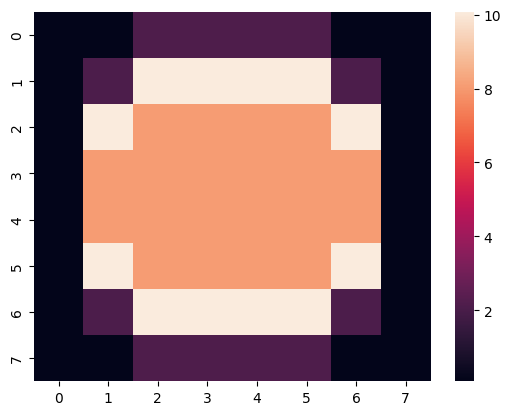

<Axes: >

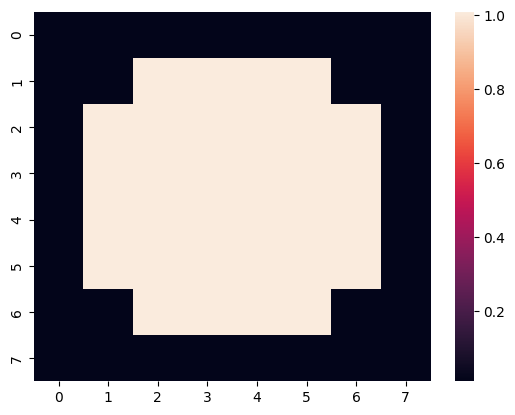

In [97]:
image_padded= jnp.pad(image,((2,2),(2,2)))
grad_x = jnp.gradient(image_padded,axis=0)
grad_y = jnp.gradient(image_padded,axis=1)
grad_x = jnp.power(grad_x,2 )
# grad_y = jnp.power(grad_y,2 )
sum_grads= grad_x[2:-2,2:-2]#+grad_y[2:-2,2:-2]
sum_grads_new= jnp.multiply(sum_grads,image)
sum_grads_new= sum_grads*8+image*8
                            
# sum_grads= sum_grads/jnp.max(sum_grads.flatten())
import seaborn as sns
import matplotlib.pylab as plt
# print(f"image \n {pd.DataFrame(jnp.round(image,1))} \n sobeled \n {pd.DataFrame(jnp.round(sum_grads_new,1))}")
sns.heatmap(sum_grads_new)
plt.show()
sns.heatmap(image)



In [98]:
def diff_round(x):
    """
    differentiable version of round function
    """
    return x - jnp.sin(2*jnp.pi*x)/(2*jnp.pi)

v_diff_round=jax.vmap(diff_round, in_axes=(0))
v_v_diff_round=jax.vmap(v_diff_round, in_axes=(0))
v_v_v_diff_round=jax.vmap(v_v_diff_round, in_axes=(0))

def get_sobel_kernel(axis,is_forward):
    """
    return sobel kernel - tested only for 2D !!
    for 3D look into https://github.com/snapfinger/sobel-operator/blob/master/v3dedge.c
    """
    is_back = 1-is_forward
    end= jnp.array([1,2,1])
    middle =jnp.zeros(3)
    res=jnp.stack([end*(1-is_forward*2),jnp.zeros(3),end*(1-is_back*2)], axis=axis)
    return res.reshape((3,3))

def apply_sobel_and_add(image,axis,is_forward,old_conved):
    sobel= einops.rearrange(get_sobel_kernel(axis,is_forward), 'x y-> 1 x y 1')
    conved_sobels=jsp.signal.convolve(image, sobel, mode='same')
    return image+old_conved

c1=apply_sobel_and_add(image_expanded,0,0,jnp.zeros_like(image_expanded))
c2=apply_sobel_and_add(image_expanded,0,0,c1)
c3=apply_sobel_and_add(image_expanded,0,0,c2)
c4=apply_sobel_and_add(image_expanded,0,0,c3)
c4=c4/jnp.max(c4)
res= conved+ c4
res= res/jnp.max(res)
res= v_v_v_diff_round(v_v_v_diff_round(res))
print(f"res \n {pd.DataFrame(jnp.round(res[0,:,:,0],1))} \n  orig \n {pd.DataFrame(jnp.round(image,1))}")

# conved_sobels=jsp.signal.convolve(image_expanded, sobels, mode='same')

res 
      0    1    2    3    4    5    6    7
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0
2  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
3  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
4  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
5  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
6  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 
  orig 
      0    1    2    3    4    5    6    7
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0
2  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
3  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
4  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
5  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
6  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [99]:
#!! here we have sobell https://setosa.io/ev/image-kernels/
7//2

3

In [100]:
# from jax import lax, random, numpy as jnp

# def get_diameter_no_pad(r):
#     """
#     so every time we have n elements we can get n+ more elements
#     so analyzing on single axis
#     start from 1 ->1+1+1 =3 good
#     start from 3 ->3+3+1=7 good 
#     start from 7 ->7+7+1=15 good 
#     """
#     curr = 1
#     for i in range(0,r):
#         curr=curr*2+1
#     return curr

# def get_diameter_and_r(r):
#     return (get_diameter_no_pad(r)+1,get_diameter_no_pad(r)//2)

# def grow_y_2d(image):
#     return einops.repeat(image, 'h w -> h (w b)', b=2)

# def grow_x_2d(image):
#     return einops.repeat(image, 'h w -> (h b) w', b=2)


# 'bb h w -> h (w bb)'
# def grow_in_axis(mask,axis,mask_shape, repeat_einops):
#     mask= einops.repeat(mask,repeat_einops, b=2)
#     mask= mask.astype(bool)
#     mask_shape=mask.shape
#     forward=jnp.take(mask, indices=jnp.arange(1,mask_shape[axis]),axis=axis )
#     back=jnp.take(mask, indices=jnp.arange(0,mask_shape[axis]-1),axis=axis )
#     mask=jnp.logical_or(forward,back).astype(int)
#     return mask

# def get_max_mask_for_dilatation(x_axis_dils:int, y_axis_dils:int):
#     """
#     on the basis of the information how many dilatations were performed in which axes
#     we can tell the maximum size that the supervoxel can have evrything outside of this area needs to be zero
#     x_axis_dils - the amount of dilatations performed in x axis
#     y_axis_dils - the amount of dilatations performed in y axis
#     """
#     x_d,x_r=get_diameter_and_r(x_axis_dils)
#     y_d,y_r=get_diameter_and_r(y_axis_dils)
#     res= jnp.zeros((3,3))
#     res=res.at[1,1].set(1)
#     for i in range(x_axis_dils):
#         res=grow_in_axis(res,0,res.shape,'h w -> (h b) w')
#         print(res.shape)
#     for i in range(y_axis_dils):
#         res=grow_in_axis(res,1,res.shape,'h w -> h (w b)')    
#         print(res.shape)
#     return res#[0:x_d,0:]    


    
# get_max_mask_for_dilatation(1,0)


In [101]:
aa= jnp.zeros((3,3))
aa= aa.at[1,1].set(1)
# aa= einops.rearrange([jnp.zeros_like(aa),aa],'bb h w -> h (w bb)' )
aa= einops.repeat(aa, 'h w -> h (w b)', b=2)
aa= aa.astype(bool)

einops_intertwine='bb h w -> h (w bb)'
axis=1
mask_shape=aa.shape
forward=jnp.take(aa, indices=jnp.arange(1,mask_shape[axis]),axis=axis )
back=jnp.take(aa, indices=jnp.arange(0,mask_shape[axis]-1),axis=axis )
aa=jnp.logical_or(forward,back).astype(int)

aa

Array([[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0]], dtype=int32)

In [102]:
def translate_mask_in_axis(mask:jnp.ndarray, axis:int,is_forward:int,translation_val:int,mask_shape:Tuple[int]):
    """
    translates the mask in a given axis 
    also forward or backward it perform it by padding and
    take
    value of translation is described by translation_val
    """
    mask= jnp.take(mask, indices=jnp.arange(translation_val*(1-is_forward),mask_shape[axis]-translation_val* is_forward),axis=axis )
    to_pad=jnp.array([[0,0],[0,0]])
    is_back=1-is_forward
    to_pad=to_pad.at[axis,is_back].set(translation_val)
    mask= jnp.pad(mask,to_pad)
    return mask

mask = jnp.ones((4,4))
axis=1
is_forward=1
translation_val=2
mask_shape=mask.shape
rr=translate_mask_in_axis(mask,axis,is_forward,translation_val,mask_shape  )
rr

Array([[0., 0., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 1., 1.]], dtype=float32)

In [103]:
def translate_mask_in_axis(mask:jnp.ndarray, axis:int,is_forward:int,translation_val:int,mask_shape:Tuple[int]):
    """
    translates the mask in a given axis 
    also forward or backward it perform it by padding and
    take
    value of translation is described by translation_val
    """
    mask= jnp.take(mask, indices=jnp.arange(translation_val*(1-is_forward),mask_shape[axis]-translation_val* is_forward),axis=axis )
    to_pad=jnp.array([[0,0],[0,0]])
    is_back=1-is_forward
    to_pad=to_pad.at[axis,is_back].set(translation_val)
    mask= jnp.pad(mask,to_pad)
    return mask

def get_image_features(image,mask):
    """
    given image and a mask will calculate the set of image features
    that will return as a vector  
    """
    masked_image= jnp.multiply(image,mask)
    meann= jnp.sum(masked_image.flatten())/jnp.sum(mask.flatten())
    varr= jnp.power( jnp.multiply((masked_image-meann),mask  ),2)
    varr=jnp.sum(varr.flatten())/jnp.sum(mask.flatten())
    return jnp.array([meann, varr])

def get_translated_mask_variance(image,mask,translation_val,mask_shape):
    """ 
    we will make a translation of the mask
    """
    # return get_image_features(image,translate_mask_in_axis(mask,0,0,translation_val,mask_shape))
    features=jnp.stack([
        get_image_features(image,translate_mask_in_axis(mask,0,0,translation_val,mask_shape)),
        get_image_features(image,translate_mask_in_axis(mask,0,1,translation_val,mask_shape)),
        get_image_features(image,translate_mask_in_axis(mask,1,0,translation_val,mask_shape)),
        get_image_features(image,translate_mask_in_axis(mask,1,1,translation_val,mask_shape))
              ])
    feature_variance=jnp.var(features,axis=0)
    print(f"features {features} feature_variance {feature_variance}")
    return jnp.mean(feature_variance)

image = jnp.ones((8,8))
image=image.at[4,4].set(4)
mask = jnp.zeros((8,8))
mask= mask.at[2:6,2:6].set(1)
mask_shape=mask.shape
print(f"image {image.shape} mask {mask.shape} ")
get_translated_mask_variance(image,mask,2,mask_shape)

image (8, 8) mask (8, 8) 
features [[1.         0.        ]
 [1.1875     0.52734375]
 [1.         0.        ]
 [1.1875     0.52734375]] feature_variance [0.00878906 0.06952286]


Array(0.03915596, dtype=float32)

In [104]:
# jax.image.resize(sample_3d_ct, (1,1,20,20,20), "linear")
mask

Array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [105]:
jax.image.resize(mask, (16,16), "nearest")
# jax.image.resize(mask, (16,16), "linear")

Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [106]:
diameter = 15



@partial(jax.jit, static_argnames=['diameter','r'])
def getLine(curr_line,index,diameter,r):
    difff=jnp.abs(r-index)
    return jax.lax.dynamic_update_slice(curr_line, jnp.ones(diameter), (difff,)) 

v_getLine=jax.vmap(getLine, in_axes=(0,0,None,None))

def get_diamond(diameter):
    """ 
    gives diamond shape like ones array where all entries that's one norm from the center
    is no more than diameter//2 are set to 1 and rest is 0
    for 3d we can repeat it in third axis - rotate it -> get logical and - should work
    """
    r=diameter//2
    a=v_getLine(jnp.zeros((diameter,diameter*2)),jnp.arange(diameter),diameter,r).astype(bool)
    b= jnp.flip(a)
    b=b[:,diameter:]
    a=a[:,:-diameter]
    c=jnp.logical_and(a,b).astype(float)
    return c
# jnp.arange(diameter)
# print(f"a {a.shape} b {b.shape}")

In [107]:
diameter_x = 11
diameter_y = 7



@partial(jax.jit, static_argnames=['diameter','r'])
def getLine(curr_line,index,diameter,r):
    difff=jnp.abs(r-index)
    return jax.lax.dynamic_update_slice(curr_line, jnp.ones(diameter), (difff,)) 

v_getLine=jax.vmap(getLine, in_axes=(0,0,None,None))

def get_diamond(diameter_x,diameter_y ):
    """ 
    gives diamond shape like ones array where all entries that's one norm from the center
    is no more than diameter//2 are set to 1 and rest is 0
    for 3d we can repeat it in third axis - rotate it -> get logical and - should work
    """
    r_x=diameter_x//2
    r_y=diameter_y//2
    diff=r_x-r_y
    a=v_getLine(jnp.zeros((diameter_x,diameter_y*2)),jnp.arange(diameter_x),diameter_y,r_x).astype(bool)
    # a= jnp.pad(a,((0,0),(r_x-r_y,r_x-r_y)))
    print(a.astype(int))
    b= jnp.flip(a)
    b=b[:,diameter_y:]
    a=a[:,:-diameter_y]

    # b=b[:,diff:]
    # a=a[:,:-diff]

    c=jnp.logical_and(a,b).astype(float)
    return c
res=get_diamond(diameter_x,diameter_y)  
print(res.shape)
res
# jnp.arange(diameter)
# print(f"a {a.shape} b {b.shape}")

[[0 0 0 0 0 1 1 1 1 1 1 1 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 0 0]]
(11, 7)


Array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [108]:
def get_diameter_no_pad(r):
    """
    so every time we have n elements we can get n+ more elements
    so analyzing on single axis
    start from 1 ->1+1+1 =3 good
    start from 3 ->3+3+1=7 good 
    start from 7 ->7+7+1=15 good 
    """
    curr = 1
    for i in range(0,r):
        curr=curr*2+1
    return curr

def get_diameter(r):
    return get_diameter_no_pad(r)+1

def for_pad_divide_grid(current_grid_shape:Tuple[int],axis:int,r:int,shift:int,orig_grid_shape:Tuple[int],diameter:int):
    """
    helper function for divide_sv_grid in order to calculate padding
    additionally give the the right infor for cut
    """
    #calculating the length of the axis after all of the cuts and paddings
    #for example if we have no shift we need to add r at the begining of the axis
    r_to_pad=(get_diameter_no_pad(r)-1)//2

    for_pad_beg=r_to_pad*(1-shift)
    #wheather we want to remove sth from end or not depend wheater we have odd or even amountof supervoxel ids in this axis
    is_even=int((orig_grid_shape[axis]%2==0))
    is_odd=1-is_even
    to_remove_from_end= (shift*is_odd)*r_to_pad + ((1-shift)*is_even)*r_to_pad
    axis_len_prim=for_pad_beg+current_grid_shape[axis]-to_remove_from_end
    #how much padding we need to make it divisible by diameter
    for_pad_rem= np.remainder(axis_len_prim,diameter)
    to_pad_end=diameter-np.remainder(axis_len_prim,diameter)
    if(for_pad_rem==0):
        to_pad_end=0
    axis_len=axis_len_prim+to_pad_end    
    return for_pad_beg,to_remove_from_end,axis_len_prim,axis_len,to_pad_end     

def get_supervoxel_ids(shape_reshape_cfg):
    """
    In order to be able to vmap through the supervoxels we need to have a way 
    to tell what id should be present in the area we have and that was given by main part of 
    divide_sv_grid function the supervoxel ids are based on the orig_grid_shape  generally 
    we have the supervoxel every r but here as we jump every 2r we need every second id
    """
    res_grid=jnp.mgrid[1:shape_reshape_cfg.orig_grid_shape[0]+1, 1:shape_reshape_cfg.orig_grid_shape[1]+1]
    res_grid=einops.rearrange(res_grid,'p x y-> x y p')
    res_grid= res_grid[shape_reshape_cfg.shift_x: shape_reshape_cfg.orig_grid_shape[0]:2,
                    shape_reshape_cfg.shift_y: shape_reshape_cfg.orig_grid_shape[1]:2, ]
    
    return einops.rearrange(res_grid,'x y p -> (x y) p')                 

def divide_sv_grid(res_grid: jnp.ndarray,shape_reshape_cfg):
    """
    as the supervoxel will overlap we need to have a way to divide the array with supervoxel ids
    into the set of non overlapping areas - we want thos area to be maximum possible area where we could find
    any voxels associated with this supervoxels- the "radius" of this cube hence can be calculated based on the amount of dilatations made
    becouse of this overlapping we need to be able to have at least 8 diffrent divisions
    we can work them out on the basis of the fact where we start at each axis at 0 or r - and do it for
    all axis permutations 2**3 =8
    we need also to take care about padding after removing r from each axis the grid need to be divisible by 2*r+1
    as the first row and column do not grow back by construction if there is no shift we always need to add r padding rest of pad to the end
    in case no shift is present all padding should go at the end
    """
    #first we cut out all areas not covered by current supervoxels
    cutted=res_grid[0: shape_reshape_cfg.curr_image_shape[0]- shape_reshape_cfg.to_remove_from_end_x
                    ,0: shape_reshape_cfg.curr_image_shape[1]- shape_reshape_cfg.to_remove_from_end_y]
    cutted= jnp.pad(cutted,(
                        (shape_reshape_cfg.to_pad_beg_x,shape_reshape_cfg.to_pad_end_x)
                        ,(shape_reshape_cfg.to_pad_beg_y,shape_reshape_cfg.to_pad_end_y )
                        ))
    cutted=einops.rearrange( cutted,'(a x) (b y)-> (a b) x y', x=shape_reshape_cfg.diameter_x,y=shape_reshape_cfg.diameter_y)
    return cutted

def recreate_orig_shape(texture_information: jnp.ndarray,shape_reshape_cfg):
    """
    as in divide_sv_grid we are changing the shape for supervoxel based texture infrence
    we need then to recreate undo padding axis reshuffling ... to get back the original image shape
    """
    # undo axis reshuffling
    texture_information= einops.rearrange(texture_information,'(a b) x y->(a x) (b y)'
        ,a=shape_reshape_cfg.axis_len_x//shape_reshape_cfg.diameter_x
        ,b=shape_reshape_cfg.axis_len_y//shape_reshape_cfg.diameter_y, x=shape_reshape_cfg.diameter_x,y=shape_reshape_cfg.diameter_y)
    # texture_information= einops.rearrange( texture_information,'a x y->(a x y)')
    #undo padding
    texture_information= texture_information[
            shape_reshape_cfg.to_pad_beg_x: shape_reshape_cfg.axis_len_x- shape_reshape_cfg.to_pad_end_x
            ,shape_reshape_cfg.to_pad_beg_y:shape_reshape_cfg.axis_len_y- shape_reshape_cfg.to_pad_end_y  ]
    #undo cutting
    texture_information= jnp.pad(texture_information,(
                        (0,shape_reshape_cfg.to_remove_from_end_x)
                        ,(0,shape_reshape_cfg.to_remove_from_end_y )
                        ))
    return texture_information


def get_shape_reshape_constants(cfg: ml_collections.config_dict.config_dict.ConfigDict,shift_x:bool,shift_y:bool, r_x:int, r_y:int ):
    """
    provides set of the constants required for reshaping into non overlapping areas
    what will be used to analyze supervoxels separately 
    results will be saved in a frozen configuration dict
    """
    diameter_x=get_diameter(r_x)
    diameter_y=get_diameter(r_y)
    curr_image_shape= (cfg.img_size[2]//2**(cfg.r_x_total-r_x),cfg.img_size[3]//2**(cfg.r_y_total-r_y))
    shift_x=int(shift_x)
    shift_y=int(shift_y)
    to_pad_beg_x,to_remove_from_end_x,axis_len_prim_x,axis_len_x,to_pad_end_x  =for_pad_divide_grid(curr_image_shape,0,r_x,shift_x,cfg.orig_grid_shape,diameter_x)
    to_pad_beg_y,to_remove_from_end_y,axis_len_prim_y,axis_len_y,to_pad_end_y   =for_pad_divide_grid(curr_image_shape,1,r_y,shift_y,cfg.orig_grid_shape,diameter_y)

    res_cfg = config_dict.ConfigDict()
    res_cfg.to_pad_beg_x=to_pad_beg_x
    res_cfg.to_remove_from_end_x=to_remove_from_end_x
    res_cfg.axis_len_prim_x=axis_len_prim_x
    res_cfg.axis_len_x=axis_len_x
    res_cfg.to_pad_beg_y=to_pad_beg_y
    res_cfg.to_remove_from_end_y=to_remove_from_end_y
    res_cfg.axis_len_prim_y=axis_len_prim_y
    res_cfg.axis_len_y=axis_len_y
    res_cfg.to_pad_end_x=to_pad_end_x
    res_cfg.to_pad_end_y=to_pad_end_y
    res_cfg.shift_x=shift_x
    res_cfg.shift_y=shift_y
    res_cfg.orig_grid_shape=cfg.orig_grid_shape
    res_cfg.diameter_x=diameter_x
    res_cfg.diameter_y=diameter_y
    res_cfg.img_size=cfg.img_size
    res_cfg.curr_image_shape=curr_image_shape
    res_cfg = ml_collections.config_dict.FrozenConfigDict(res_cfg)

    return res_cfg

w=13
h=11
r=3
dim_stride=0
grid_shape=(w//2,h//2)
orig_grid_shape=grid_shape

cfg = config_dict.ConfigDict()

cfg.r_x_total= 3
cfg.r_y_total= 3
cfg.orig_grid_shape= orig_grid_shape
cfg.img_size=(1,1,w*8,h*8)

cfg = ml_collections.config_dict.FrozenConfigDict(cfg)

shape_reshape_cfg=get_shape_reshape_constants(cfg,True,True,2,2)

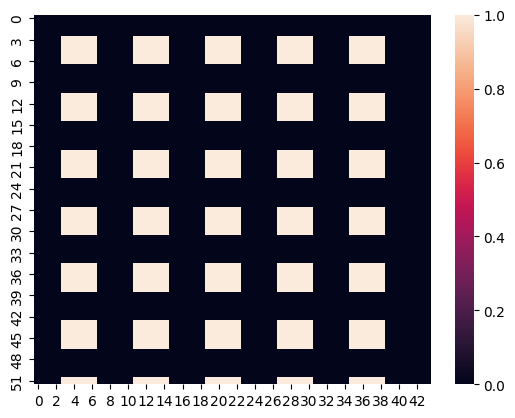

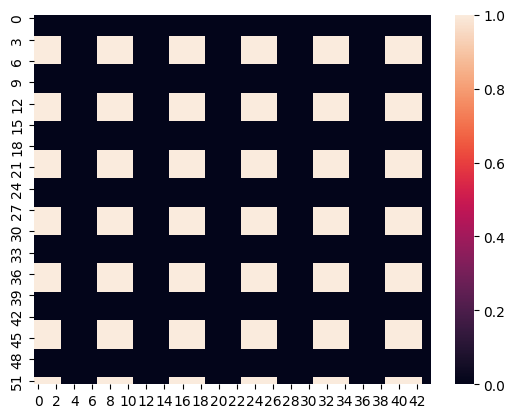

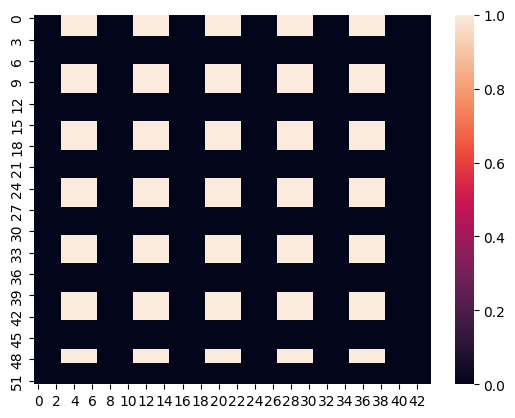

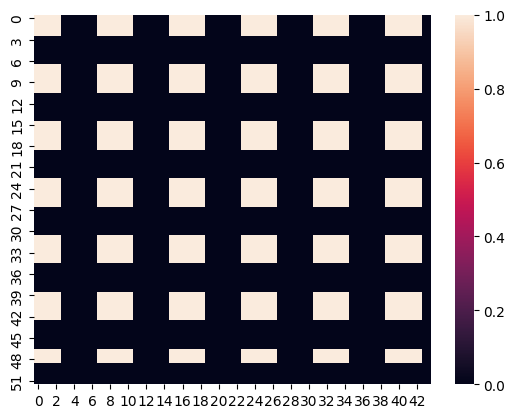

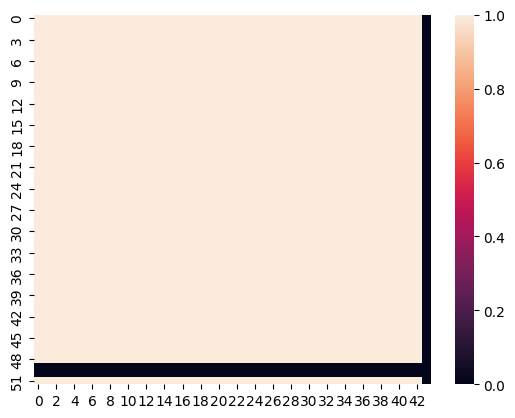

Array([[1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.]], dtype=float32)

In [109]:
import seaborn as sns
import matplotlib.pylab as plt

mask= jnp.zeros(shape_reshape_cfg.curr_image_shape)
ttcfg=get_shape_reshape_constants(cfg,True,True,2,2)
tfcfg=get_shape_reshape_constants(cfg,True,False,2,2)
ftcfg=get_shape_reshape_constants(cfg,False,True,2,2)
ffcfg=get_shape_reshape_constants(cfg,False,False,2,2)

def set_non_overlapping_regions(area: jnp.ndarray, shape_reshape_cfg:ml_collections.config_dict.config_dict.ConfigDict):
    """
    sets non overlapping regions of each mask to 1
    """
    p_x=((shape_reshape_cfg.diameter_x-1)//2)-1#-shape_reshape_cfg.shift_x
    p_y=((shape_reshape_cfg.diameter_y-1)//2)-1#-shape_reshape_cfg.shift_y
    s_x=shape_reshape_cfg.shift_x
    s_y=shape_reshape_cfg.shift_y
    return area.at[p_x+s_x:-(p_x-s_x),p_y+s_y:-(p_y-s_y)].set(1)

v_set_non_overlapping_regions=jax.vmap(set_non_overlapping_regions, in_axes=(0,None))

def get_overlap_and_recreate(mask,shape_reshape_cfg):
    a=divide_sv_grid(mask,shape_reshape_cfg)
    a=v_set_non_overlapping_regions(a,shape_reshape_cfg)
    return recreate_orig_shape(a,shape_reshape_cfg)
tt= get_overlap_and_recreate(mask,ttcfg)
tf= get_overlap_and_recreate(mask,tfcfg)
ft= get_overlap_and_recreate(mask,ftcfg)
ff= get_overlap_and_recreate(mask,ffcfg)
sns.heatmap(tt)
plt.show()
sns.heatmap(tf)
plt.show()
sns.heatmap(ft)
plt.show()
sns.heatmap(ff)
plt.show()
summ=tt+tf+ft+ff
sns.heatmap(summ)
plt.show()


summ
# recreate_orig_shape(tt_mask,ttcfg).shape


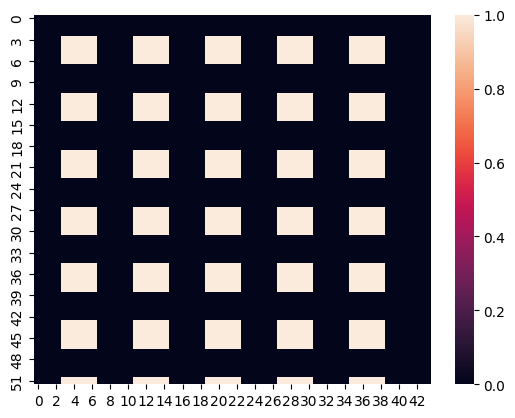

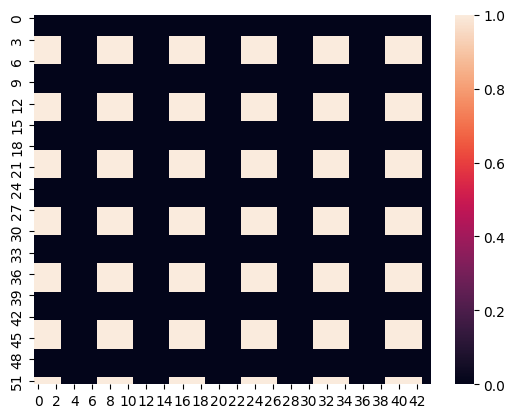

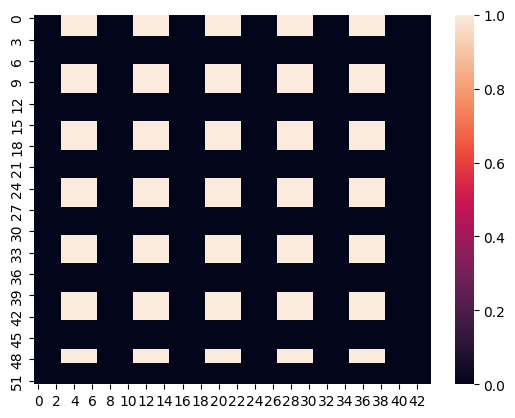

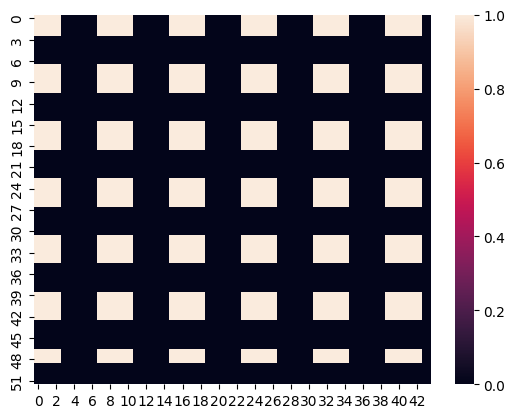

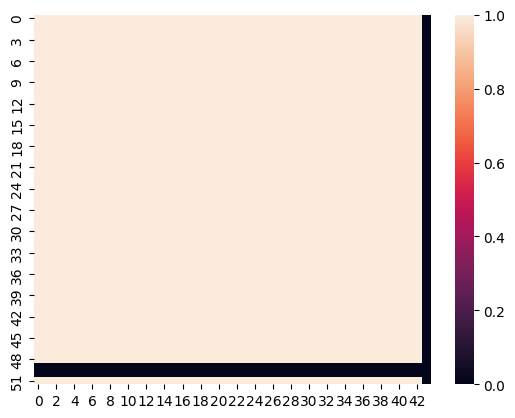

mask (52, 44) summ.shape (52, 44)


In [110]:
import seaborn as sns
import matplotlib.pylab as plt

mask= jnp.zeros(shape_reshape_cfg.curr_image_shape)
ttcfg=get_shape_reshape_constants(cfg,True,True,2,2)
tfcfg=get_shape_reshape_constants(cfg,True,False,2,2)
ftcfg=get_shape_reshape_constants(cfg,False,True,2,2)
ffcfg=get_shape_reshape_constants(cfg,False,False,2,2)

def set_non_overlapping_regions(area,diameter_x:int
                                ,diameter_y:int
                                ,index:int
                                ):
    """
    sets non overlapping regions of each mask to 1
    """
    shift_x= jnp.remainder(index,2)
    shift_y=index//2
    p_x=((diameter_x-1)//2)-1#-shape_reshape_cfg.shift_x
    p_y=((diameter_y-1)//2)-1#-shape_reshape_cfg.shift_y
    s_x=shift_x
    s_y=shift_y
    beg_x=p_x+s_x
    end_x=(p_x-s_x)
    beg_y=p_y+s_y
    end_y= (p_y-s_y)
    oness = jnp.ones((diameter_x-p_x*2,diameter_y-p_y*2))
    # area= jnp.zeros((diameter_x,diameter_y ))
    return jax.lax.dynamic_update_slice(area, oness, (beg_x,beg_y))
    # return jnp.pad(oness,((beg_x,end_x),(beg_y,end_y)))


    # return jax.lax.dynamic_update_slice(area, y, (2,))
    
    # return area.at[p_x+s_x:-(p_x-s_x),p_y+s_y:-(p_y-s_y)].set(1)


v_set_non_overlapping_regions=jax.vmap(set_non_overlapping_regions, in_axes=(0,None,None,None))

diameter_x=ttcfg.diameter_x
diameter_y=ttcfg.diameter_y

def get_overlap_and_recreate(mask,shape_reshape_cfg,index):
    a=divide_sv_grid(mask,shape_reshape_cfg)
    a=v_set_non_overlapping_regions(a,diameter_x,diameter_y,index)
    return recreate_orig_shape(a,shape_reshape_cfg)

tt= get_overlap_and_recreate(mask,ttcfg,3)
tf= get_overlap_and_recreate(mask,tfcfg,1)
ft= get_overlap_and_recreate(mask,ftcfg,2)
ff= get_overlap_and_recreate(mask,ffcfg,0)
sns.heatmap(tt)
plt.show()
sns.heatmap(tf)
plt.show()
sns.heatmap(ft)
plt.show()
sns.heatmap(ff)
plt.show()
summ=tt+tf+ft+ff
sns.heatmap(summ)
plt.show()

print(f"mask {mask.shape} summ.shape {summ.shape}")
# recreate_orig_shape(tt_mask,ttcfg).shape


In [111]:
[ttcfg.axis_len_x
,tfcfg.axis_len_x
,ftcfg.axis_len_x
,ffcfg.axis_len_x]

[56, 56, 56, 56]

In [112]:
def shape_reshape_constants_to_array(shape_reshape_cfg: ml_collections.config_dict.config_dict.ConfigDict):
    """
    change shape reshape configuration dict into jax array for compatibility reasons
    """
    res_cfg=shape_reshape_cfg

    return jnp.array([
        res_cfg.to_pad_beg_x #0
        ,res_cfg.to_remove_from_end_x#1
        ,res_cfg.axis_len_prim_x#2
        ,res_cfg.axis_len_x#3
        ,res_cfg.to_pad_beg_y#4
        ,res_cfg.to_remove_from_end_y#5
        ,res_cfg.axis_len_prim_y#6
        ,res_cfg.axis_len_y#7
        ,res_cfg.to_pad_end_x#8
        ,res_cfg.to_pad_end_y#9
        ,res_cfg.shift_x#10
        ,res_cfg.shift_y#11
        ,res_cfg.diameter_x#12
        ,res_cfg.diameter_y#13
        ,res_cfg.img_size[0]#14
        ,res_cfg.img_size[1]#15
        ,res_cfg.img_size[2]#16
        ,res_cfg.img_size[3]#17
        ,res_cfg.curr_image_shape[0]#18
        ,res_cfg.curr_image_shape[1]#19
        ,res_cfg.orig_grid_shape[0]#20
        ,res_cfg.orig_grid_shape[1]#21
    ])

def array_toshape_reshape_constants(shape_reshape_arr: jnp.ndarray):
    """
    change shape reshape configuration dict into jax array for compatibility reasons
    """
    res_cfg = config_dict.ConfigDict()

    res_cfg.to_pad_beg_x=shape_reshape_arr[0]#0
    res_cfg.to_remove_from_end_x=shape_reshape_arr[1]#1
    res_cfg.axis_len_prim_x=shape_reshape_arr[2]#2
    res_cfg.axis_len_x=shape_reshape_arr[3]#3
    res_cfg.to_pad_beg_y=shape_reshape_arr[4]#4
    res_cfg.to_remove_from_end_y=shape_reshape_arr[5]#5
    res_cfg.axis_len_prim_y=shape_reshape_arr[6]#6
    res_cfg.axis_len_y=shape_reshape_arr[7]#7
    res_cfg.to_pad_end_x=shape_reshape_arr[8]#8
    res_cfg.to_pad_end_y=shape_reshape_arr[9]#9
    res_cfg.shift_x=shape_reshape_arr[10]#10
    res_cfg.shift_y=shape_reshape_arr[11]#11
    res_cfg.diameter_x=shape_reshape_arr[12]#12
    res_cfg.diameter_y=shape_reshape_arr[13]#13
    res_cfg.img_size=(shape_reshape_arr[14:18])
    res_cfg.curr_image_shape=(shape_reshape_arr[18:20])
    res_cfg.orig_grid_shape=(shape_reshape_arr[20:])
    
    return ml_collections.config_dict.FrozenConfigDict(res_cfg)

ttcfg

axis_len_prim_x: 52
axis_len_prim_y: 41
axis_len_x: !!python/object/apply:numpy.core.multiarray.scalar
- &id001 !!python/object/apply:numpy.dtype
  args:
  - i8
  - false
  - true
  state: !!python/tuple
  - 3
  - <
  - null
  - null
  - null
  - -1
  - -1
  - 0
- !!binary |
  OAAAAAAAAAA=
axis_len_y: !!python/object/apply:numpy.core.multiarray.scalar
- *id001
- !!binary |
  MAAAAAAAAAA=
curr_image_shape: !!python/tuple
- 52
- 44
diameter_x: 8
diameter_y: 8
img_size: !!python/tuple
- 1
- 1
- 104
- 88
orig_grid_shape: !!python/tuple
- 6
- 5
shift_x: 1
shift_y: 1
to_pad_beg_x: 0
to_pad_beg_y: 0
to_pad_end_x: !!python/object/apply:numpy.core.multiarray.scalar
- *id001
- !!binary |
  BAAAAAAAAAA=
to_pad_end_y: !!python/object/apply:numpy.core.multiarray.scalar
- *id001
- !!binary |
  BwAAAAAAAAA=
to_remove_from_end_x: 0
to_remove_from_end_y: 3

In [113]:
a=array_toshape_reshape_constants(shape_reshape_constants_to_array(ttcfg))
a.orig_grid_shape

Array([6, 5], dtype=int32)

In [114]:
resized_image= jnp.arange(10)
resized_image=einops.repeat(resized_image,'b->a b',a=4)
resized_image= resized_image.at[1,:].set(jnp.arange(10)*2)
shape_reshape_index=0

lax.dynamic_slice(resized_image, (0, 0), (3,2))

resized_image[0:3,0:2]
# lax.dynamic_slice_in_dim(resized_image, shape_reshape_index, 1, axis=0)[0]

Array([[0, 1],
       [0, 2],
       [0, 1]], dtype=int32)

In [115]:
aa= jnp.ones((3,3,3))

aa=lax.dynamic_slice_in_dim(aa, 1, 1, axis=0)[0,:]
lax.dynamic_slice_in_dim(aa, 1, 1, axis=0)[0,:]

Array([1., 1., 1.], dtype=float32)

In [116]:
a= jnp.array([3])

rem = jnp.remainder(a,2)

rem,a//2

(Array([1], dtype=int32), Array([1], dtype=int32))

In [117]:
jnp.absolute(1)

Array(1, dtype=int32, weak_type=True)